In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Displaying Image

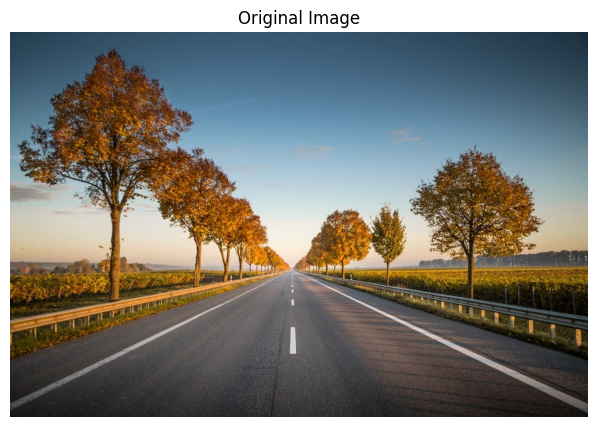

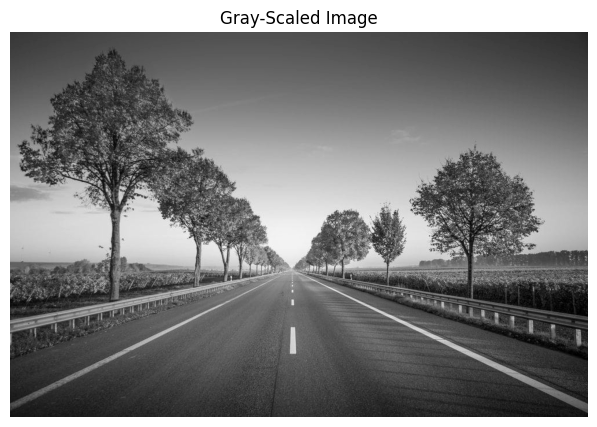

In [10]:

image1 = cv2.imread('lane2.jpg')
image_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    
plt.figure(figsize=(10, 5))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(gray_image, cmap="gray")
plt.title("Gray-Scaled Image")
plt.axis("off")
plt.show()



2. Smoothing

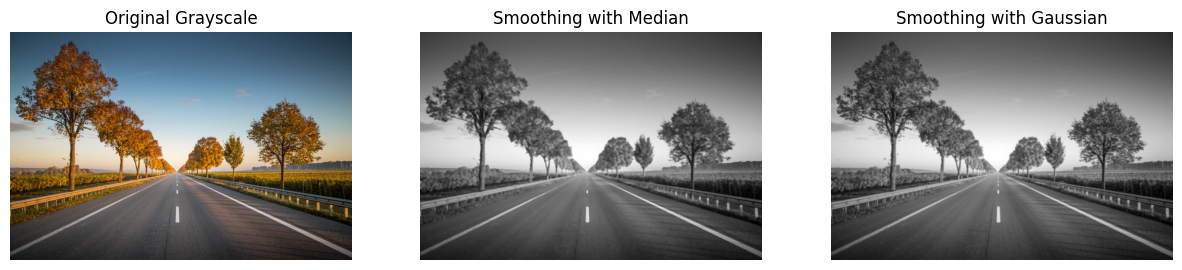

In [11]:
smoothed_median = cv2.medianBlur(gray_image, 5)
smoothed_gaussian = cv2.GaussianBlur(gray_image, (5,5), 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_rgb, cmap="gray")
ax[0].set_title("Original Grayscale")
ax[0].axis("off")

ax[1].imshow(smoothed_median, cmap="gray")
ax[1].set_title("Smoothing with Median")
ax[1].axis("off")

ax[2].imshow(smoothed_gaussian, cmap="gray")
ax[2].set_title("Smoothing with Gaussian")
ax[2].axis("off")

plt.show()

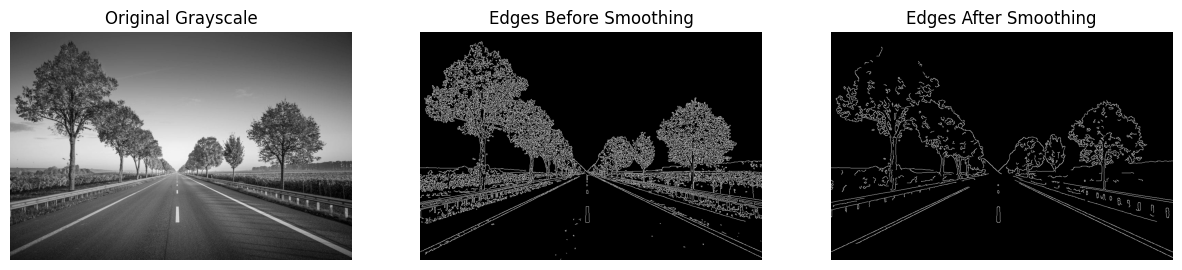

In [12]:
edges_before = cv2.Canny(gray_image, 100, 200)
edges = cv2.Canny(smoothed_median, 100, 200)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gray_image, cmap="gray")
ax[0].set_title("Original Grayscale")
ax[0].axis("off")

ax[1].imshow(edges_before, cmap="gray")
ax[1].set_title("Edges Before Smoothing")
ax[1].axis("off")

ax[2].imshow(edges, cmap="gray")
ax[2].set_title("Edges After Smoothing")
ax[2].axis("off")

plt.show()

In [13]:
print(edges.shape)

(667, 1000)


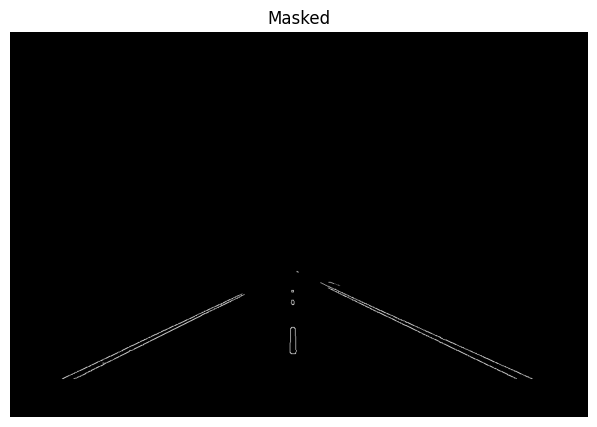

In [14]:
mask = np.zeros_like(edges) 
height, width = edges.shape
polygon = np.array([[
    (0, 0.9*height), (width, 0.9*height), (width//2, 0.62*height)
]], dtype=np.int32)

cv2.fillPoly(mask, polygon, 255)
roi = cv2.bitwise_and(edges, mask)


plt.figure(figsize=(10, 5))
plt.imshow(roi, cmap="gray")
plt.title("Masked")
plt.axis("off")
plt.show()

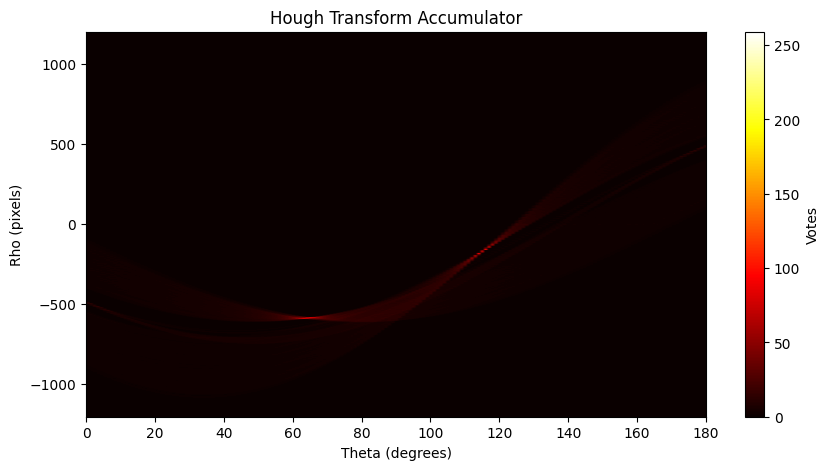

In [15]:
# Hough Transform parameters
theta_range = np.deg2rad(np.arange(0, 181))  #nsw +d2r?
diag_len = int(np.sqrt(width**2 + height**2)) 
rho_range = np.arange(-diag_len, diag_len, 1)  #nsw
H = np.zeros((len(rho_range), len(theta_range)), dtype=np.int32)  # Accumulator

y_idxs, x_idxs = np.nonzero(roi)  #since we need to process only edge pixels

# Voting
for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for t_idx, theta in enumerate(theta_range):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = np.where(rho_range == rho)[0][0]  # (array([4]),) so used 00
        H[rho_idx, t_idx] += 1

plt.figure(figsize=(10, 5))
plt.imshow(H, cmap="hot", aspect="auto", extent=[0, 180, -diag_len, diag_len])
plt.title("Hough Transform Accumulator")
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.colorbar(label="Votes")
plt.show()


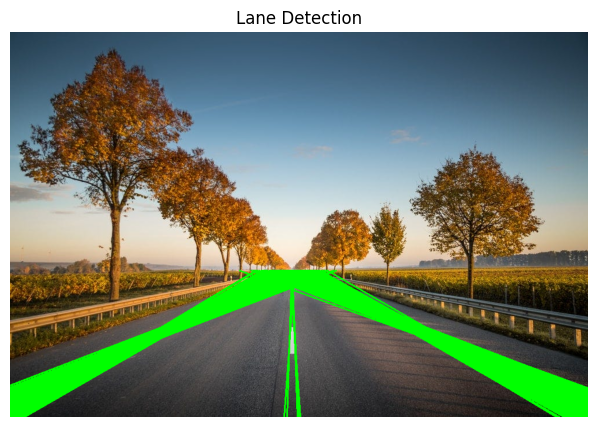

In [8]:
# Extract peaks from the accumulator
threshold = 30  
lines = np.argwhere((H > 30))

image_with_lines = image_rgb.copy()
y_min = int(0.62 * height)  
y_max = height  

for rho_idx, theta_idx in lines:
    rho = rho_range[rho_idx]
    theta = theta_range[theta_idx]
    a, b = np.cos(theta), np.sin(theta)

    x1 = int((rho - y_min * b) / a)
    x2 = int((rho - y_max * b) / a)

    cv2.line(image_with_lines, (x1, y_min), (x2, y_max), (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(image_with_lines)
plt.title("Lane Detection")
plt.axis("off")
plt.show()



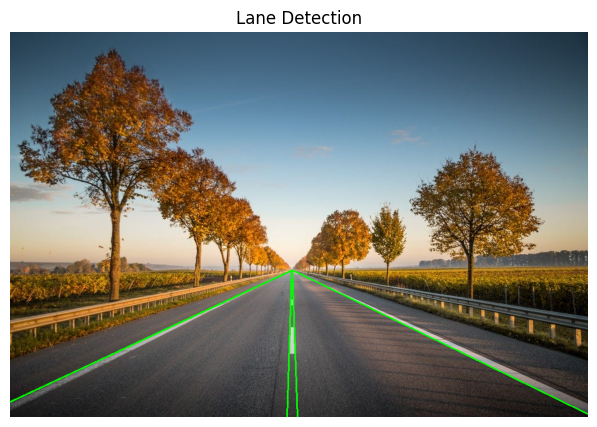

In [ ]:
# Extract peaks from the accumulator
threshold = 32 
lines = np.argwhere(H > threshold)

lines = sorted(lines, key=lambda idx: H[idx[0], idx[1]], reverse=True)
filtered_lines = []
rho_theta_used = set() #avoiding duplicates

rho_tolerance = 100 
theta_tolerance = np.deg2rad(10) 

for rho_idx, theta_idx in lines:
    rho = rho_range[rho_idx]
    theta = theta_range[theta_idx]
    if any(abs(rho - r) < rho_tolerance and abs(theta - t) < theta_tolerance 
           for r, t in rho_theta_used):
        continue  
    rho_theta_used.add((rho, theta))
    filtered_lines.append((rho_idx, theta_idx))


image_with_lines = image_rgb.copy()
y_min = int(0.62 * height) #parameter here
y_max = height 

for rho_idx, theta_idx in filtered_lines:
    rho = rho_range[rho_idx]
    theta = theta_range[theta_idx]
    a, b = np.cos(theta), np.sin(theta)
    x1 = int((rho - y_min * b) / a)
    x2 = int((rho - y_max * b) / a)
    
    cv2.line(image_with_lines, (x1, y_min), (x2, y_max), (0, 255, 0), 2)

plt.figure(figsize=(10, 5))
plt.imshow(image_with_lines)
plt.title("Lane Detection")
plt.axis("off")
plt.show()


(np.float64(-0.5), np.float64(999.5), np.float64(666.5), np.float64(-0.5))

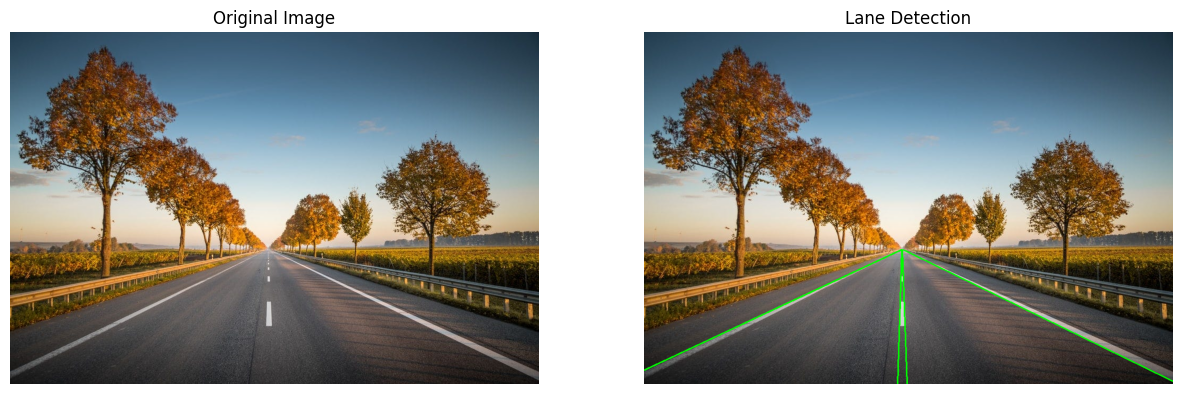

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(image_with_lines)
ax[1].set_title("Lane Detection")
ax[1].axis("off")